In [ ]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import torch
from IPython import embed
from torchvision.transforms import ToTensor, Compose, CenterCrop, Pad, Resize
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from data_split import create_split_dataframe


In [ ]:
## create unpadded images first by adding the following lines to main
#masking the drone image using the boundary
# with rasterio.open(img_path) as raster:
#     img, _ = rasterio.mask.mask(raster, boundary, crop=False)
#
# unpadded_img= img
# img = pad(img, patch_size) #padding image to make patches even
# carbon_distribution = compute_carbon_distribution(site, img.shape, trees, mean, covariance)
#
# assert img.shape[1:] == carbon_distribution.shape
#
# np.save(paths["dataset"] + "sites/" + f"{site}_carbon", carbon_distribution)
#
# im = Image.fromarray(np.moveaxis(img, 0, -1)[:,:,:3])
# im_unpadded= Image.fromarray(np.moveaxis(unpadded_img, 0, -1)[:,:,:3])
# im.save(paths["dataset"] + "sites/" + f"{site}_image.png")
# im_unpadded.save(paths["dataset"] + "sites/" + f"{site}_unpadded_image.png")


In [ ]:
path_to_dataset="/Users/victoriabarenne/ai4good/dataset/"
path_to_refores= "/Users/victoriabarenne/ai4good/reforesTree/"

In [ ]:
final_df= pd.read_csv(path_to_refores+"mapping/final_dataset.csv")

In [ ]:
final_df.head()


In [103]:
my_df=  final_df[['img_name', 'Xmin', 'Ymin', 'Xmax', 'Ymax', 'AGB', 'carbon']]
my_df.head()

,img_name,Xmin,Ymin,Xmax,Ymax,AGB,carbon
0,Carlos Vera Guevara RGB,3332.557861,8324.092411,3661.390137,8669.616425,4.293300,1.674387
1,Carlos Vera Guevara RGB,3162.579834,10453.233398,3431.632324,10684.467041,7.702971,3.004159
2,Carlos Vera Guevara RGB,2893.605713,8549.011108,3095.620605,8756.257812,6.769828,2.640233
3,Carlos Vera Guevara RGB,2595.111084,10008.712402,2765.227295,10170.253418,3.933601,1.534104
4,Carlos Vera Guevara RGB,7849.691879,7723.626862,8039.557648,7902.768402,13.862143,5.406236


In [104]:
sites= np.unique(final_df["img_name"])
print(sites)

['Carlos Vera Arteaga RGB' 'Carlos Vera Guevara RGB' 'Flora Pluas RGB'
 'Leonor Aspiazu RGB' 'Manuel Macias RGB' 'Nestor Macias RGB']


In [166]:
tree_crowns = pd.DataFrame([] ,columns=["tree_img", "coord", "site", "carbon"])

for site in sites:
    print(site)
    df_site= my_df[my_df['img_name']==site]
    print(len(df_site))
    image_site= cv2.imread(f"/Users/victoriabarenne/ai4good/dataset/sites/{site}_unpadded_image.png")
    print(image_site.shape, type(image_site))
    for i in range(len(df_site)):
        tree_coord= np.array(my_df.iloc[i][['Xmin', 'Ymin', 'Xmax', 'Ymax']]).astype(int)
        carbon= my_df.iloc[i]['carbon'].item()
        tree_img= image_site[tree_coord[1]:tree_coord[3], tree_coord[0]:tree_coord[2], :]
        new_df=pd.DataFrame([[tree_img, tree_coord, site, carbon]], columns=tree_crowns.columns)
        tree_crowns=pd.concat([tree_crowns, new_df], ignore_index=True)


Carlos Vera Arteaga RGB
743
(15053, 15297, 3) <class 'numpy.ndarray'>
Carlos Vera Guevara RGB
929
(12305, 12425, 3) <class 'numpy.ndarray'>
Flora Pluas RGB
846
(15578, 16782, 3) <class 'numpy.ndarray'>
Leonor Aspiazu RGB
789
(13855, 17134, 3) <class 'numpy.ndarray'>
Manuel Macias RGB
484
(10879, 13748, 3) <class 'numpy.ndarray'>
Nestor Macias RGB
872
(13024, 15003, 3) <class 'numpy.ndarray'>


In [195]:
print(tree_crowns["tree_img"][0].shape)

(345, 329, 3)


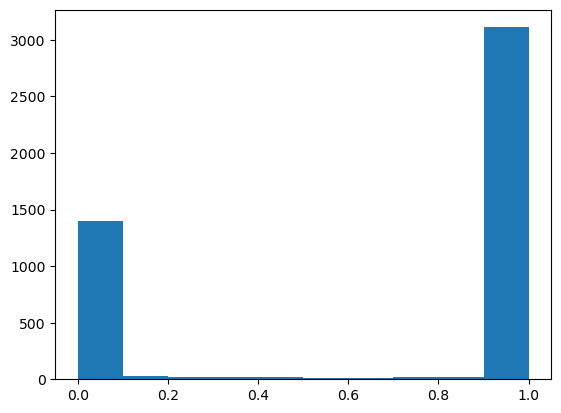

In [168]:
white_percentage= np.zeros(len(tree_crowns))
for i in range(len(tree_crowns)):
    tree_img= tree_crowns.iloc[i]["tree_img"]
    surface= tree_img.shape[0]*tree_img.shape[1]
    if surface>0:
        white_percentage[i]= np.sum(np.all(tree_img==0, axis=2))/surface
    elif surface==0:
        white_percentage[i]=1
plt.hist(white_percentage)
plt.show()

In [175]:
white_threshold= 0.8
tree_crowns_filtered= tree_crowns.iloc[white_percentage<white_threshold]
tree_crowns_filtered= tree_crowns_filtered.reset_index(drop=True)
print(f"Only {len(tree_crowns_filtered)}/{len(tree_crowns)} of the bounding boxes were inside the site boundaries")

Only 1529/4663 of the bounding boxes were inside the site boundaries


In [176]:
for site in sites:
    tree_crowns_site=tree_crowns[tree_crowns["site"]==site]
    tree_crowns_filtered_site=tree_crowns_filtered[tree_crowns_filtered["site"]==site]
    print(f"{site}: {len(tree_crowns_filtered_site)}/{len(tree_crowns_site)} of the bounding boxes were inside the site boundaries")

Carlos Vera Arteaga RGB: 268/743 of the bounding boxes were inside the site boundaries
Carlos Vera Guevara RGB: 244/929 of the bounding boxes were inside the site boundaries
Flora Pluas RGB: 315/846 of the bounding boxes were inside the site boundaries
Leonor Aspiazu RGB: 273/789 of the bounding boxes were inside the site boundaries
Manuel Macias RGB: 164/484 of the bounding boxes were inside the site boundaries
Nestor Macias RGB: 265/872 of the bounding boxes were inside the site boundaries


In [179]:
tree_crowns_filtered.head()


,tree_img,coord,site,carbon
0,"[[[185, 212, 202], [148, 184, 177], [121, 145,...","[3332, 8324, 3661, 8669]",Carlos Vera Arteaga RGB,1.674387
1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[3162, 10453, 3431, 10684]",Carlos Vera Arteaga RGB,3.004159
2,"[[[168, 187, 207], [181, 196, 211], [196, 201,...","[7849, 7723, 8039, 7902]",Carlos Vera Arteaga RGB,5.406236
3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[7729, 2401, 7897, 2573]",Carlos Vera Arteaga RGB,3.079940
4,"[[[73, 134, 111], [167, 225, 209], [159, 209, ...","[9142, 3868, 9357, 3997]",Carlos Vera Arteaga RGB,5.825807


In [184]:
transform= Compose([ToTensor(), CenterCrop(800)])
tree_crowns_final=pd.DataFrame([], columns=["tree_img", "site", "carbon"])

for i in range(len(tree_crowns_filtered)):
    tree_img= tree_crowns_filtered.iloc[i]["tree_img"]
    transformed_img= transform(tree_img)
    site = tree_crowns_filtered["site"][i]
    carbon= tree_crowns_filtered["carbon"][i]

    new_df=pd.DataFrame([[transformed_img, site, carbon]], columns=tree_crowns_final.columns)
    tree_crowns_final=pd.concat([tree_crowns_final, new_df], ignore_index=True)

print(len(tree_crowns_final), len(tree_crowns_filtered))



1529 1529


In [185]:
print(tree_crowns_final["tree_img"][0].shape)
tree_crowns_final.head()

torch.Size([3, 800, 800])


,tree_img,site,carbon
0,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(...",Carlos Vera Arteaga RGB,1.674387
1,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(...",Carlos Vera Arteaga RGB,3.004159
2,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(...",Carlos Vera Arteaga RGB,5.406236
3,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(...",Carlos Vera Arteaga RGB,3.079940
4,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(...",Carlos Vera Arteaga RGB,5.825807


In [189]:
train, val, test= create_split_dataframe("", tree_crowns_filtered, [4,1,1])
print(len(train), len(val), len(test))


1017 268 244


In [191]:
class TreeCrown(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform= transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, item):
        """
        Loading samples based on the information contained
        in self.df.
        """
        site = self.df["site"][item]
        image = self.df["tree_img"][item]
        carbon = self.df["carbon"][item]


        if self.transform is not None:
            image = self.transform(image)

        return image, carbon, site


In [192]:
def train_val_test_dataset(data:pd.DataFrame, splits, transform):
    train, val, test= create_split_dataframe("", data, splits)
    train_dataset= TreeCrown(train, transform)
    val_dataset = TreeCrown(val, transform)
    test_dataset = TreeCrown(test, transform)

    return train_dataset, val_dataset, test_dataset

def train_val_test_dataloader(data: pd.DataFrame, splits, batch_size, transform=None):
    train_dataset, val_dataset, test_dataset= train_val_test_dataset( data, splits, transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader, test_loader


In [204]:
train_loader, val_loader, test_loader= train_val_test_dataloader(tree_crowns_final, splits=[4,1,1], batch_size=32, transform=Resize(224))

In [214]:
tree_img_sampled, carbon_sample, site_sample= next(iter(train_loader))
print(tree_img_sampled.shape, carbon_sample.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32])
